## Introduction
Variational Autoencoders (VAEs) are a unique type of deep learning model that, like traditional autoencoders, are composed of two primary components: an encoder and a decoder. The encoder utilizes convolutional neural networks (CNNs) and downsampling techniques to learn a compressed, probabilistic latent space that represents the input data in a lower-dimensional form. The decoder, on the other hand, leverages CNNs and upsampling methods to reconstruct the data from this latent space by sampling from the learned distribution. Unlike standard autoencoders, VAEs incorporate a regularization term that encourages the latent space to approximate a Gaussian distribution, allowing for the generation of new data points that resemble the original input. When well-trained, the VAE's decoder can produce reconstructions that are nearly indistinguishable from the original data. VAEs are commonly applied in tasks such as anomaly detection, image denoising, and data generation. In this project, we employ a VAE to colorize landscape images.

<img src = 'https://miro.medium.com/v2/resize:fit:1100/format:webp/1*ET6FM_KEmwa2N4qgW2MglQ.png' >

## Import necessary libraries

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Input, Flatten, Dense, Reshape, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

# Ensuring reproducibility
tf.random.set_seed(42)


### Getting landscape image data,resizing them and appending in array
To get the image in sorted order i have defined the function sorted_alphanumeric. Here, I have used open cv library to read and resize images. Finally images are normalized and are converted to array and are appended in empty list

In [3]:
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
path = '/kaggle/input/landscape-image-colorization/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '1500.jpg':
        break
    else:
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
path = '/kaggle/input/landscape-image-colorization/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '1500.jpg':
        break
     else:
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))

 21%|██        | 1500/7129 [00:16<01:02, 90.35it/s] 


### Plotting Color image and it's corresponding grayscale image

In [4]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)

    plt.show()

**Plotting image pair**

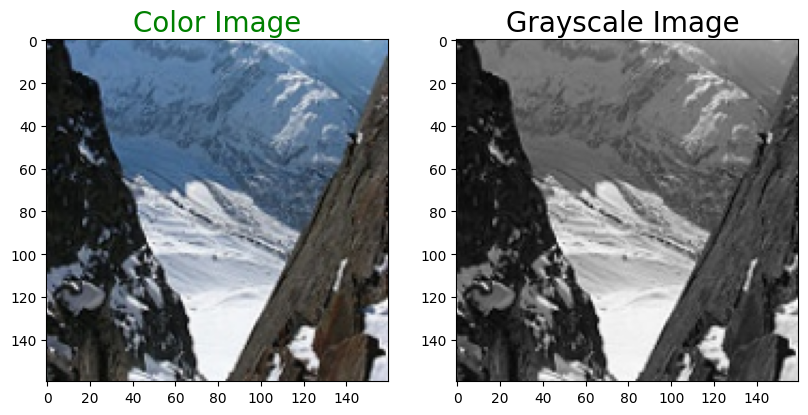

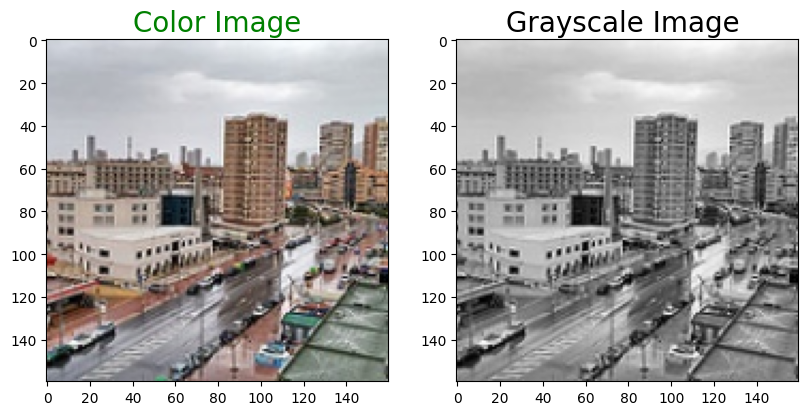

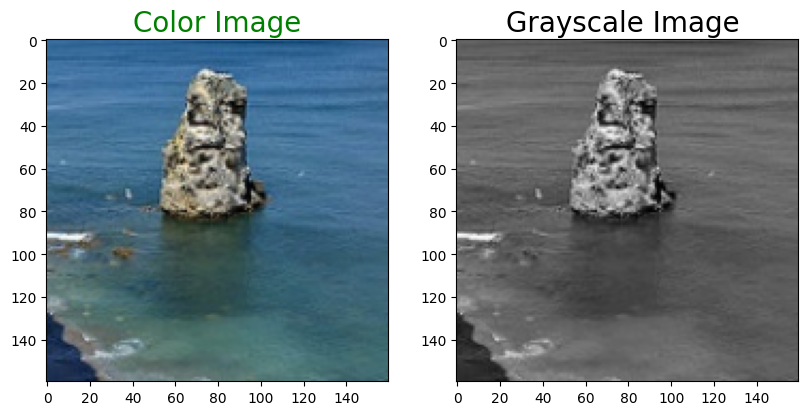

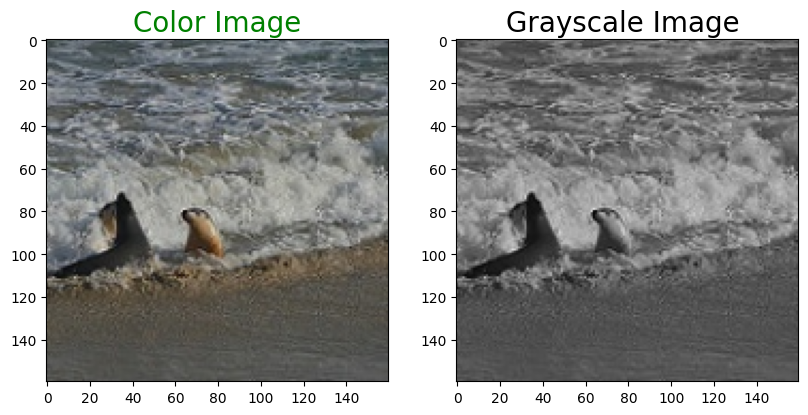

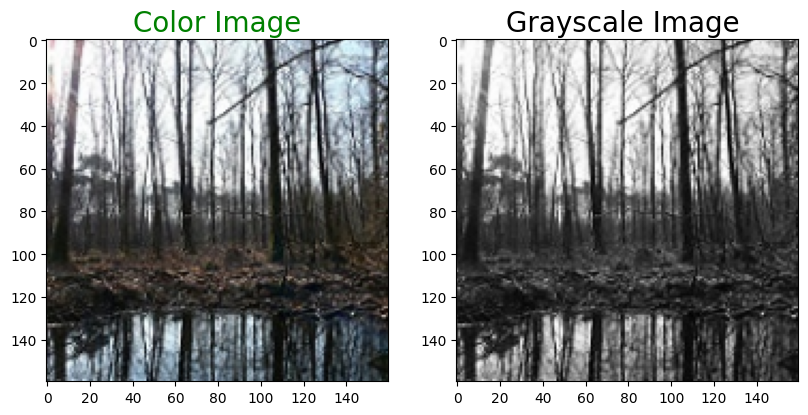

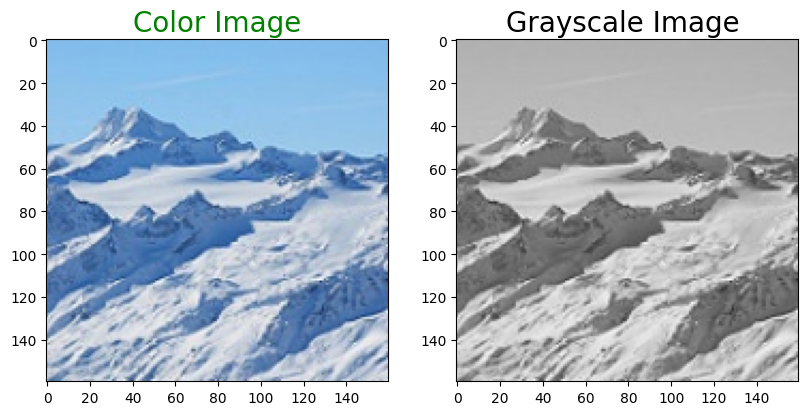

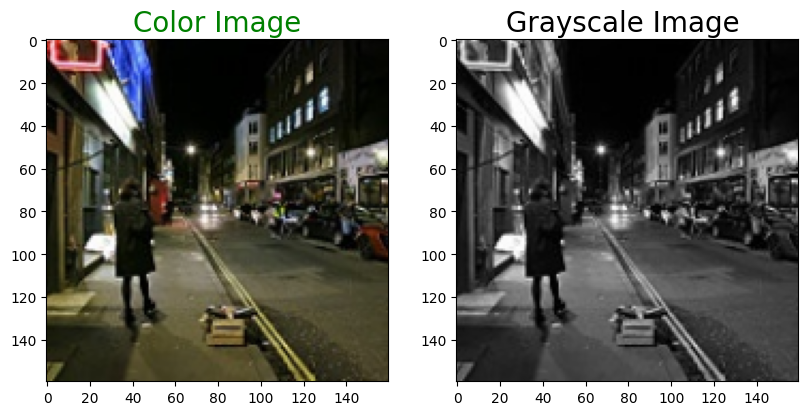

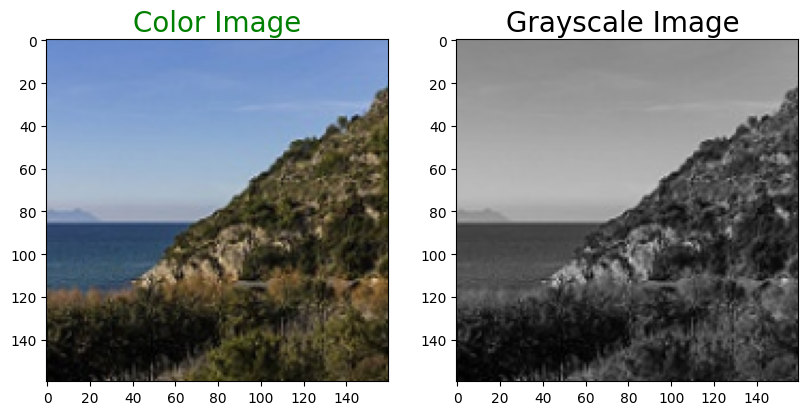

In [5]:
for i in range(10,18):
     plot_images(color_img[i],gray_img[i])

### Slicing and reshaping
Out of 5000 images I have sliced them to two part. train images consist 4000 images  while test images contains 1000 images.
After slicing the image array, I reshaped them so that images can be fed directly into our encoder network

In [6]:
# Assuming you have 1000 images in each list
total_images = len(gray_img)  # This should be 1000 based on your input

# Decide on a split point. Let's use 800 for training and 200 for testing
split_point = int(total_images * 0.8)

# Splitting the data
train_gray_image = gray_img[:split_point]
train_color_image = color_img[:split_point]

test_gray_image = gray_img[split_point:]
test_color_image = color_img[split_point:]

# Reshaping the image arrays
train_g = np.reshape(train_gray_image, (len(train_gray_image), SIZE, SIZE, 3))
train_c = np.reshape(train_color_image, (len(train_color_image), SIZE, SIZE, 3))
print('Train color image shape:', train_c.shape)

test_g = np.reshape(test_gray_image, (len(test_gray_image), SIZE, SIZE, 3))
test_c = np.reshape(test_color_image, (len(test_color_image), SIZE, SIZE, 3))
print('Test color image shape:', test_c.shape)


Train color image shape: (1200, 160, 160, 3)
Test color image shape: (300, 160, 160, 3)


# VAE Loss Function

In [7]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, Input, Lambda # Import necessary layers

# Custom VAE Loss function without KL loss (KL handled by custom layer)
@tf.function
def vae_loss(inputs, output_img):
    # Reconstruction loss
    mse_loss_fn = tf.keras.losses.MeanSquaredError()
    reconstruction_loss = mse_loss_fn(inputs, output_img)
    
    # Normalize by the number of pixels
    reconstruction_loss /= (SIZE * SIZE * 3)

    return reconstruction_loss


## Defining our model
Encoder layer of our model consist blocks of Convolution layer with different number of kernel and kernel_size. Here, Convolution is used for downsampling. Similary, Decoder layer of our model consist of transpose convolution layer with different kernel size. Here, Decoder layer upsample image downsampled by encoder. Since there is feature loss between the encoder and decoder layers so inorder to prevent feature loss i have concatenate corresponding encoder and decoder layers. Check U_Net architecture for better understanding......

In [8]:
img = img.astype('float32') / 255.0  # Normalize pixel valuesimport numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K

# Define downsample and upsample functions
def down(filters, kernel_size, apply_batch_normalization=True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters, kernel_size, padding='same', strides=2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(layers.LeakyReLU())
    return downsample

def up(filters, kernel_size, dropout=False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size, padding='same', strides=2))
    if dropout:
        upsample.add(layers.Dropout(0.2))
    upsample.add(layers.LeakyReLU())
    return upsample

# Latent space dimension
latent_dim = 100

# Custom KL divergence layer
class KLDivergenceLayer(tf.keras.layers.Layer):
    def __init__(self, beta=0.001, **kwargs):
        super(KLDivergenceLayer, self).__init__(**kwargs)
        self.beta = beta  # Weight for KL divergence

    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        kl_loss *= self.beta  # Apply the weighting factor
        self.add_loss(kl_loss)  # Add KL divergence to the model's total loss
        return inputs

# Now modify the model to include this KL divergence layer
latent_dim = 100

# Encoder
inputs = layers.Input(shape=[160, 160, 3])
d1 = down(128, (3, 3), False)(inputs)  # Output: (80, 80, 128)
d2 = down(128, (3, 3), False)(d1)      # Output: (40, 40, 128)
d3 = down(256, (3, 3), True)(d2)       # Output: (20, 20, 256)
d4 = down(512, (3, 3), True)(d3)       # Output: (10, 10, 512)
d5 = down(512, (3, 3), True)(d4)       # Output: (5, 5, 512)

# Flatten and add dense layers for the latent variables
flatten = layers.Flatten()(d5)
dense = layers.Dense(256, activation='relu')(flatten)

# Latent variables
z_mean = layers.Dense(latent_dim)(dense)
z_log_var = layers.Dense(latent_dim)(dense)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Add the KL divergence layer
z_mean, z_log_var = KLDivergenceLayer(beta=0.001)([z_mean, z_log_var])

# Decoder
decoder_input = layers.Dense(256, activation='relu')(z)
decoder_dense = layers.Dense(512 * 5 * 5, activation='relu')(decoder_input)
reshape = layers.Reshape((5, 5, 512))(decoder_dense)

# Upsampling and concatenation
u1 = up(512, (3, 3), False)(reshape)  # Output: (10, 10, 512)
u1 = layers.concatenate([u1, d4])     # Concatenate with d4: (10, 10, 512)

u2 = up(256, (3, 3), False)(u1)       # Output: (20, 20, 256)
u2 = layers.concatenate([u2, d3])     # Concatenate with d3: (20, 20, 256)

u3 = up(128, (3, 3), False)(u2)       # Output: (40, 40, 128)
u3 = layers.concatenate([u3, d2])     # Concatenate with d2: (40, 40, 128)

u4 = up(128, (3, 3), False)(u3)       # Output: (80, 80, 128)
u4 = layers.concatenate([u4, d1])     # Concatenate with d1: (80, 80, 128)

u5 = up(64, (3, 3), False)(u4)        # Output: (160, 160, 64)

output_img = layers.Conv2D(3, (2, 2), strides=1, padding='same')(u5)  # Final Output: (160, 160, 3)

# Modify the model definition to return only the image output
vae = models.Model(inputs, output_img)  # Only return the image output



print(f"Min value in train_g: {np.min(train_g)}, Max value in train_g: {np.max(train_g)}")
print(f"Min value in train_c: {np.min(train_c)}, Max value in train_c: {np.max(train_c)}")



# Compile the VAE model with a lower learning rate
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=vae_loss)

vae.summary()





Min value in train_g: 0.0, Max value in train_g: 1.0
Min value in train_c: 0.0, Max value in train_c: 1.0


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 80, 80,    │      3,584 │ input_layer[0][0] │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 40, 40,    │    147,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 20, 20,    │    296,192 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 10, 10,    │  1,182,208 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 5, 5, 512) │  2,361,856 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12800)     │          0 │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  3,277,056 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100)       │     25,700 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100)       │     25,700 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 100)       │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     25,856 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 12800)     │  3,289,600 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 5, 5, 512) │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 10, 10,    │  2,359,808 │ reshape[0][0]     │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 10,    │          0 │ sequential_5[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 20, 20,    │  2,359,552 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 20, 20,    │          0 │ sequential_6[0][… │
│ (Concatenate)       │ 512)              │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 40, 40,    │    589,952 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                 

 Total params: 16,387,979 (62.52 MB)

 Trainable params: 16,385,419 (62.51 MB)

 Non-trainable params: 2,560 (10.00 KB)

# Fitting the Model

In [ ]:
# Custom callback to compute test loss and accuracy at the end of each epoch
class LossAndAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Compute test loss at the end of each epoch using test_g and test_c
        test_loss = self.model.evaluate(test_g, test_c, verbose=0)
        
        # Define a custom accuracy metric
        # Here, we define it as the percentage of pixels within a certain tolerance
        pred = self.model.predict(test_g)
        tolerance = 0.05  # Tolerance for pixel accuracy
        accuracy = np.mean(np.abs(pred - test_c) < tolerance)
        
        # Print training loss, test loss, and accuracy
        #print(f"Epoch {epoch + 1}: Training Loss: {logs['loss']:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

# Instantiate the custom callback
loss_and_accuracy_callback = LossAndAccuracyCallback()

# Training the VAE model with custom callback
history = vae.fit(train_g, train_c, epochs=30, batch_size=50, verbose=1, callbacks=[loss_and_accuracy_callback])



Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step- l
24/24 ━━━━━━━━━━━━━━━━━━━━ 258s 11s/step - loss: 3.1983e-06
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step- lo
24/24 ━━━━━━━━━━━━━━━━━━━━ 249s 10s/step - loss: 1.6537e-06
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step- l
24/24 ━━━━━━━━━━━━━━━━━━━━ 250s 10s/step - loss: 4.6919e-07
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step- l
24/24 ━━━━━━━━━━━━━━━━━━━━ 250s 10s/step - loss: 2.9785e-07
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step- lo
24/24 ━━━━━━━━━━━━━━━━━━━━ 250s 10s/step - loss: 2.6106e-07
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step- l
24/24 ━━━━━━━━━━━━━━━━━━━━ 249s 10s/step - loss: 2.3975e-07
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step- l
24/24 ━━━━━━━━━━━━━━━━━━━━ 249s 10s/step - loss: 2.2284e-07
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step- l
24/24 ━━━━━━━━━━━━━━━━━━━━ 250s 10s/step - loss: 2.0948e-07
Epoch 9/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step- l
24/24 ━━━━━━━━━━━━━━━━━━━━ 252s 11s/step 

# plotting colorized image along with grayscale and color image

In [ ]:
# Define function to plot images: original color, grayscale, and predicted color
def plot_images(color, grayscale, predicted):
    plt.figure(figsize=(15, 15))
    
    # Plot original color image
    plt.subplot(1, 3, 1)
    plt.title('Color Image', color='green', fontsize=20)
    plt.imshow(color)
    
    # Plot grayscale input image
    plt.subplot(1, 3, 2)
    plt.title('Grayscale Image', color='black', fontsize=20)
    plt.imshow(grayscale, cmap='gray')  # Ensure the grayscale image is displayed correctly
    
    # Plot predicted color image
    plt.subplot(1, 3, 3)
    plt.title('Predicted Image', color='red', fontsize=20)
    plt.imshow(predicted)
    
    # Display the plot
    plt.show()

# Loop to predict and plot images for indices 50 to 58
for i in range(50, 58):
    # Reshape the test grayscale image for prediction
    grayscale_input = test_g[i].reshape(1, SIZE, SIZE, 3)  # Assuming test_g contains grayscale images reshaped to (SIZE, SIZE, 3)
    
    # Predict the color image using the VAE model
    predicted = np.clip(vae.predict(grayscale_input), 0.0, 1.0).reshape(SIZE, SIZE, 3)  # Reshape the prediction to the image size
    
    # Plot the original color, grayscale, and predicted color images
    plot_images(test_c[i], test_g[i][:, :, 0], predicted)  # Using the first channel of test_g for the grayscale plot


# Thanks for your visit.
## Any suggestions to improve this model is highly appreciated.
# Feel free to  comment